# ASX Sentiment

---


## 1. Sentiment Analysis

Use the [newsapi](https://newsapi.org/) to pull the latest news articles for ASX.

In [9]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from newsapi import NewsApiClient

from nltk.corpus import stopwords, reuters
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt

# Code to download wordnet corpora
import nltk
nltk.download('wordnet')

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jawwadilyas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jawwadilyas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# Read your api key environment variable
load_dotenv()
api_key = os.getenv("NEWS_API_KEY")

In [11]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [12]:
# Fetch the ASX news articles
asx_news = newsapi.get_everything(q="asx", language="en",sort_by="relevancy")

In [13]:
asx_news

{'status': 'ok',
 'totalResults': 2510,
 'articles': [{'source': {'id': 'reuters', 'name': 'Reuters'},
   'author': 'Reuters Staff',
   'title': 'Australia shares set to track Wall Street lower as U.S. Treasury yields firm - Reuters',
   'description': 'Australian shares were poised to inch lower on Tuesday after a weak showing on Wall Street overnight as rising U.S. Treasury yields and inflation concerns pressured stocks. The local share price index futures fell 0.2%, a 80.9-point discount to the underlying…',
   'url': 'https://www.reuters.com/article/australia-stocks-morning-idUSL4N2KS4FZ',
   'urlToImage': 'https://s1.reutersmedia.net/resources_v2/images/rcom-default.png?w=800',
   'publishedAt': '2021-02-22T21:27:00Z',
   'content': 'By Reuters Staff\r\nFeb 23 (Reuters) - Australian shares were poised to inch\r\nlower on Tuesday after a weak showing on Wall Street overnight\r\nas rising U.S. Treasury yields and inflation concerns press… [+315 chars]'},
  {'source': {'id': 'reuters

In [14]:
# Create the Bitcoin sentiment scores DataFrame
asx_sentiments = []

for article in asx_news["articles"]:
    try:
        text = article["content"]
        date = article["publishedAt"][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        asx_sentiments.append({
            "text": text,
            "date": date,
            "compound": compound,
            "positive": pos,
            "negative": neg,
            "neutral": neu
            
        })
        
    except AttributeError:
        pass
    
# Create DataFrame
asx_df = pd.DataFrame(asx_sentiments)

# Reorder DataFrame columns
cols = ["compound", "negative", "neutral","positive", "text"]
asx_df = asx_df[cols]

asx_df.head()

,compound,negative,neutral,positive,text
0,-0.0258,0.130,0.716,0.153,By Reuters Staff\r\nFeb 23 (Reuters) - Austral...
1,0.0772,0.123,0.723,0.154,By Reuters Staff\r\nFeb 24 (Reuters) - Austral...
2,0.7717,0.000,0.801,0.199,By Reuters Staff\r\nFeb 8 (Reuters) - Australi...
3,0.8126,0.038,0.711,0.251,* Miners benefit as iron ore prices climb on r...
4,0.2960,0.000,0.934,0.066,By Reuters Staff\r\nFeb 2 (Reuters) - Australi...


In [15]:
# Describe the ASX Sentiment
asx_df.describe()

,compound,negative,neutral,positive
count,20.000000,20.000000,20.000000,20.000000
mean,0.356035,0.055400,0.791000,0.153600
std,0.447222,0.068145,0.085866,0.072081
min,-0.735100,0.000000,0.670000,0.060000
25%,0.051450,0.000000,0.721250,0.091000
50%,0.391850,0.019000,0.782000,0.153500
75%,0.755875,0.120500,0.860000,0.198250
max,0.883400,0.234000,0.934000,0.305000


---

## 2. Natural Language Processing
---
###   Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word.
2. Remove Punctuation.
3. Remove Stopwords.

In [16]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
from string import punctuation
import re

In [17]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
sw = set(stopwords.words('english'))

# Expand the default stopwords list if necessary
sw_list = [',', '', 'https', 'http']


In [18]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    
    # Create a tokenized list of the words
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    words = word_tokenize(re_clean)
                        
    # Lemmatize words into root words
    lem = [lemmatizer.lemmatize(word) for word in words]
    
    # Convert the words to lowercase
    words = [word.lower() for word in lem]
    
    # Remove the punctuation from text
    table = str.maketrans('', '', string.punctuation)
    pword = [w.translate(table) for w in words]
    
    # Remove the stop words
    tokens = [w for w in pword if not w in sw.union(sw_list)]
    
    return tokens

In [19]:
# Create a new tokens column for ASX
asx_df['tokens'] = asx_df.apply(lambda x : tokenizer(x['text']), axis=1)

asx_df.head()

,compound,negative,neutral,positive,text,tokens
0,-0.0258,0.130,0.716,0.153,By Reuters Staff\r\nFeb 23 (Reuters) - Austral...,"[reuters, stafffeb, reuters, australian, share..."
1,0.0772,0.123,0.723,0.154,By Reuters Staff\r\nFeb 24 (Reuters) - Austral...,"[reuters, stafffeb, reuters, australian, share..."
2,0.7717,0.000,0.801,0.199,By Reuters Staff\r\nFeb 8 (Reuters) - Australi...,"[reuters, stafffeb, reuters, australian, share..."
3,0.8126,0.038,0.711,0.251,* Miners benefit as iron ore prices climb on r...,"[miners, benefit, iron, ore, price, climb, rob..."
4,0.2960,0.000,0.934,0.066,By Reuters Staff\r\nFeb 2 (Reuters) - Australi...,"[reuters, stafffeb, reuters, australian, share..."


---

### NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [20]:
from collections import Counter
from nltk import ngrams

In [21]:
# Generate the ASX N-grams where N=2
btc_bigram_counts = [Counter(ngrams(tokens, n=2)) for tokens in asx_df.tokens]
dict(btc_bigram_counts[0].most_common(10))

{('reuters', 'stafffeb'): 1,
 ('stafffeb', 'reuters'): 1,
 ('reuters', 'australian'): 1,
 ('australian', 'share'): 1,
 ('share', 'poised'): 1,
 ('poised', 'inchlower'): 1,
 ('inchlower', 'tuesday'): 1,
 ('tuesday', 'weak'): 1,
 ('weak', 'showing'): 1,
 ('showing', 'wall'): 1}

In [22]:
# Function token_count generates the top 10 words for ASX
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [23]:
# Use token_count to get the top 10 words for ASX
bigstr = []
for tokens in asx_df.tokens:
    bigstr += tokens
asx_token_count = token_count(bigstr)
asx_token_count

[('reuters', 32),
 ('char', 20),
 ('australian', 15),
 ('share', 15),
 ('stafffeb', 10),
 ('stock', 8),
 ('wall', 6),
 ('energy', 6),
 ('month', 6),
 ('poised', 5)]

---

### Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 8.5]

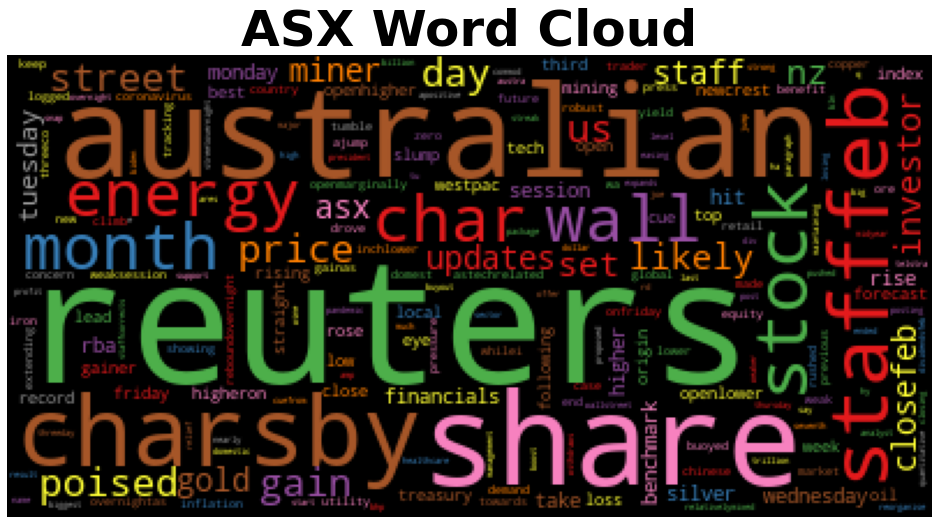

In [25]:
# Generate the ASX word cloud
asx_corpus = ''
sw = set(stopwords.words('english') + sw_list)
for token in asx_df.text:
    asx_corpus += token
    
long_string = " ".join(str(x) for x in tokenizer(asx_corpus))
wc = WordCloud(collocations=False, colormap='Set1',background_color='black').generate(long_string)
plt.title('ASX Word Cloud', fontsize=50, fontweight='bold')
plt.imshow(wc)
plt.axis("off")
plt.show()

---
## 3. Named Entity Recognition

In this section, you will build a named entity recognition model for both Bitcoin and Ethereum, then visualize the tags using SpaCy.

In [26]:
import spacy
from spacy import displacy

In [27]:
# Download the language model for SpaCy
# !python -m spacy download en_core_web_sm

In [28]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

---
### ASX NER

In [29]:
# Concatenate all of the ASX text together
asx_concat = asx_df['text'].str.cat()

In [30]:
# Run the NER processor on all of the text
doc = nlp(asx_concat)

# Add a title to the document
doc.user_data["title"] = "ASX NER"

In [31]:
# Render the visualization
displacy.render(doc, style='ent')

In [32]:
# List all Entities
entities = [ent.text for ent in doc.ents]
entities

['Reuters',
 'Feb 23',
 'Reuters',
 'Australian',
 'Tuesday',
 'overnight',
 'U.S. Treasury',
 'Reuters',
 'Feb 24',
 'Reuters',
 'Australian',
 'Wednesday',
 'Reuters',
 'Reuters',
 'Australian',
 'Monday',
 'zero',
 'three',
 'Chinese',
 'Feb 8',
 'Reuters',
 'Reuters',
 'Feb 2',
 'Reuters',
 'Australian',
 'Tuesday',
 'overnight',
 'Reuters',
 'Feb 26',
 'Reuters',
 'Australian',
 'Friday',
 'U.S',
 'U.S',
 'Reuters',
 'Reuters',
 'Australian',
 'Tuesday',
 'Reuters',
 'Reuters',
 'Australian',
 'Monday',
 'Friday',
 'Reuters',
 'Feb 25',
 'Reuters',
 'Australian',
 'Thursday',
 'Wall Street',
 '200',
 'nearly a month',
 '76.2',
 'Reuters',
 'Australian',
 'Tu',
 'Reuters',
 'Reuters',
 'Australian',
 'Wednesday',
 'U.S.',
 'Wall\r\nStreet',
 'overnight',
 'Reuters',
 'Reuters',
 'Australian',
 'the week on Monday',
 'last week',
 'Reuters',
 '5%',
 '2%',
 '6%',
 '16%',
 'as much as 5%',
 'Treasury',
 '3',
 'Reuters',
 'over 100 dollars',
 'mid-year',
 'three-day',
 'Feb 1',
 'Reute

---

---